In [1]:

import os
import numpy as np
import librosa # used for loading and extracting features from audio files
import librosa.display 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # converts categorical labels into numerical form 
from sklearn.metrics import classification_report, confusion_matrix # metrics for evaluating model performance
import tensorflow as tf
from tensorflow.keras.models import Sequential # allows stacking layers sequantially 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Bidirectional, Dense, Dropout, Flatten, BatchNormalization, TimeDistributed
from tensorflow.keras.utils import to_categorical


In [2]:

def extract_features(file_path, max_pad_len=100):
    """ Extracts MFCC features from an audio file"""
    # load audio file
    signal, sr = librosa.load(file_path, sr=16000)
    # Extract 40 MFFC features from the audio file
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    # Ensure all MFCC feature arrays have the same time dimension
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc

def load_audio_files(directory, max_pad_len=100):
    """ Loads audio files, extracts MFCC features, and encodes labels """
    data, labels = [], [] # empty lists to store features and labels
    for label in os.listdir(directory):
        class_path = os.path.join(directory, label)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                if file_path.endswith(".wav"):
                    features = extract_features(file_path, max_pad_len)
                    data.append(features)
                    labels.append(label)
    return np.array(data), labels

train_dir = "cats_dogs/train"
test_dir = "cats_dogs/test"

train_data, train_labels = load_audio_files(train_dir)
test_data, test_labels = load_audio_files(test_dir)

# Encode labels (convert text labels to numerical labels)
label_encoder = LabelEncoder()
train_labels = to_categorical(label_encoder.fit_transform(train_labels))
test_labels = to_categorical(label_encoder.transform(test_labels))

# Reshape for CNN input
train_data = train_data[..., np.newaxis]
test_data = test_data[..., np.newaxis]

print(f"Train Data Shape: {train_data.shape}, Test Data Shape: {test_data.shape}")


Train Data Shape: (210, 40, 100, 1), Test Data Shape: (67, 40, 100, 1)


In [3]:

def build_model(input_shape, num_classes):
    """ Builds a CNN + BiLSTM model """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        TimeDistributed(Flatten()),
        Bidirectional(LSTM(64, return_sequences=False)),

        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (40, 100, 1)
num_classes = train_labels.shape[1]

model = build_model(input_shape, num_classes)
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 100, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 100, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 1600)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │       852,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 880,066 (3.36 MB)

 Trainable params: 879,874 (3.36 MB)

 Non-trainable params: 192 (768.00 B)

In [4]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(train_data, train_labels, epochs=20, batch_size=16, validation_data=(test_data, test_labels), callbacks=[early_stopping, reduce_lr])

model.save("catdog_audio_model.h5")


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7814 - loss: 0.5676 - val_accuracy: 0.4478 - val_loss: 0.9499 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8077 - loss: 0.4067 - val_accuracy: 0.5373 - val_loss: 1.2542 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8739 - loss: 0.3185 - val_accuracy: 0.6567 - val_loss: 0.8645 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9472 - loss: 0.1860 - val_accuracy: 0.6866 - val_loss: 0.8950 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9635 - loss: 0.1331 - val_accuracy: 0.7612 - val_loss: 0.8073 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9734 - loss: 0.0774 - val_accuracy: 0.7463 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9762 - loss: 0.0804 - val_acc

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:
              precision    recall  f1-score   support

         cat       0.88      0.92      0.90        39
         dog       0.88      0.82      0.85        28

    accuracy                           0.88        67
   macro avg       0.88      0.87      0.88        67
weighted avg       0.88      0.88      0.88        67



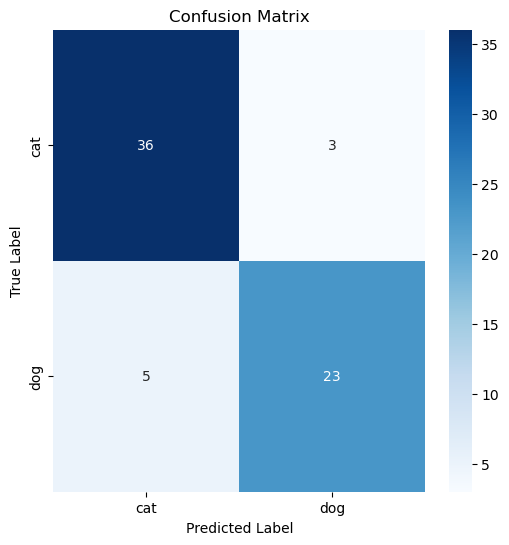

In [6]:

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
